**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2023</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: June 08, 2023 23:59 (GMT+3)</center></h4>

## **MNIST RGB Inpainting**

### **Homework Description**

In this assignment, you are asked to design and train two different neural network models for image the inpainting task. In short, inpainting is a process of filling in the missing parts of an image. You will be applying this task on the MNIST RGB dataset, which is created for this homework by processing a subset of the original [MNIST](http://yann.lecun.com/exdb/mnist/) images. It contains RGB digit images from 0 to 1 colored in black, red, blue, or green. You can see a subset of the dataset below. The download link of the dataset is provided in the following parts.

![MNIST RGB Samples](https://drive.google.com/uc?export=view&id=1uy0VENXeb6If-i3uxgDVtnk4qDj7eq_3)

**Using PyTorch is mandatory** for this assignment. You are requested to **submit only a single *.ipynb file** in your submissions (no report needed). If you want to provide further explanations about your work, you can add Markdown cells for this purpose. From [this link](https://www.markdownguide.org/), you can get familiar with the Markdown syntax if you need. Upload your homework with the following filename convention: **\<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb**

Note that this assignment needs a CUDA-enabled GPU to be able to train the models in a reasonable time. If you do not have one, it is suggested to use the [Colab](https://colab.research.google.com/) environment.

**Contact:** [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

### **Importing the Libraries**

In the cell below,  some utilities that you can make use of in this assignment are imported. You can edit these imports considering your implementation as long as you use PyTorch.

In [53]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

### **Environment Check**

In the cell below, you can test whether hardware acceleration with GPU is enabled in your machine or not. If it is enabled, the printed device should be 'cuda'. 

**Do not change the cell**.

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cuda
GPU Name: Tesla T4
Total GPU Memory: 14.7 GB


### **Setting Library Seeds for Reproducibility**

To make a fair evaluation, the seed values are set for random sampling methods in PyTorch, NumPy, and Python random library. 

**Do not change the cell**

In [55]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [56]:
seed_everything(464)

### **Preparing the Dataset**

The MNIST RGB dataset is downloadable from [this link](https://drive.google.com/file/d/1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ/view?usp=share_link). If you are using Colab or a Linux machine, you can uncomment and run the below cell to download and extract the dataset automatically.

In [57]:
import gdown # Library to download files from Google Drive
!gdown 1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ # Google Drive ID of the zip file to be downloaded
!unzip -oq mnist_dataset_rgb # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

Downloading...
From: https://drive.google.com/uc?id=1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ
To: /content/mnist_dataset_rgb.zip
100% 63.4M/63.4M [00:00<00:00, 134MB/s]


### **Implementing a Custom Dataset [20 Points]**

In this part, you are requested to implement a custom PyTorch dataset class that reads MNIST RGB images from a dataset split folder. There are two split folders called training and test in the dataset. The model class should take the root directory of a split in the \_\_init\_\_ function and read the images accordingly. Before returning the requested images, you should apply the following steps:

* Apply bicubic interpolation using PIL to resize the images from (28,28) to (32,32) resolution.
* Convert images to Tensor object
* Normalize tensor values to scale them in the range of (-1,1)

Note that reading images in the \_\_getitem\_\_ function makes the training process slow for this dataset because reading such small-sized images as a batch is slower than the forward pass process of a simple neural network. Therefore, it is suggested to read and store the images in an array in the \_\_init\_\_ function and return them in the \_\_getitem\_\_ function when they are requested by the DataLoader object.

In [58]:
class MnistDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir

        images = []

        # Tensor transformation initializations
        convert_tensor = transforms.ToTensor()
        normalize_tensor = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

        # Get the images
        for i in range(0,10):
          path = root_dir + "/" + str(i) + "/"
          for file in os.listdir(path):
            img = convert_tensor(Image.open(path + file).resize((32,32), Image.BICUBIC))
            images.append(normalize_tensor(img))

        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, data_id):
        return self.images[data_id]

Create a dataset and a data loader object for training and test splits. Set batch sizes to 64 and 512 for training and test data loaders, respectively. Enable shuffling in the training data loader and disable it in the test data loader.

In [59]:
train_dataset = MnistDataset(root_dir="/content/mnist_dataset_rgb/training")
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = MnistDataset(root_dir="/content/mnist_dataset_rgb/test")
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

**Do not change** the below code. If your implementation is correct, you should be seeing a grid of MNIST RGB images properly.

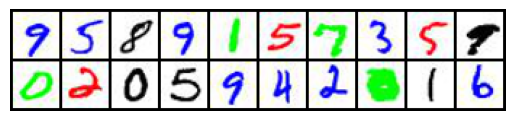

In [60]:
## Uncomment the cell when the dataloader is ready

images = next(iter(train_dataloader))
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### **Constructing Autoencoder Networks [30 Points]**

Autoencoder networks learn how to compress and reconstruct input data. It consists of two subnetworks called the encoder and the decoder. The encoder network compresses the input data, and the decoder network regenerates the data from its compressed version. In this part of the homework, you are requested to implement two different autoencoder networks, which are fully connected and convolutional autoencoders.

#### **Fully Connected Autoencoder [15 Points]**

Fully connected networks consist of multiple [linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). The figure of the architecture is provided below, where the number of nodes is kept small for simplification. 

![Fully Connected Autoencoder Architecture](https://drive.google.com/uc?export=view&id=1JeDQtjvWVoT5dZhVxesQp_XiqAnUvi1i)

In this part, you are requested to implement the layers and the forward function of the model. You should flatten the input image before feeding it to the network and unflatten it when the final activations are obtained. The (input_size, output_size) pairs of the layers should be defined as follows:

**Encoder:**
- (3\*32\*32, 256)
- (256, 64)
- (64, 16)

**Decoder:**
- (16, 64)
- (64, 256)
- (256, 3\*32\*32)

In each layer, [1D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers.

In [61]:
class MnistAutoencoderFC(nn.Module):
    def __init__(self):
        super(MnistAutoencoderFC, self).__init__()

        self.functions = nn.ModuleList([
            # 1st encoding layer
            nn.Linear(3*32*32, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            # 2nd encoding layer
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),

            # 3rd encoding layer
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2),

            # 1st decoding layer
            nn.Linear(16, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),

            # 2nd decoding layer
            nn.Linear(64, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            # 3rd decoding layer
            nn.Linear(256, 3*32*32),
            nn.Tanh()
        ])

    def forward(self, x):

        # Flatten the images
        x = x.view(x.size(0), -1)

        # Pass the flattened images to the layer functions in a loop
        for layer in self.functions:
            x = layer(x)

        # Return unflattened images
        return x.view(x.size(0), 3, 32, 32)
        

#### **Convolutional Autoencoder [15 Points]**

In this part, you are requested to implement an autoencoder model using convolutional layers. The architecture of a convolutional autoencoder is shown in the below figure.

![Convolutional Autoencoder Architecture](https://drive.google.com/uc?export=view&id=18Ztf-zhMFC_IXDTnvGCUeGgZx-7duu0o)

 The (in_channel, out_channel) pairs of the layers should be defined as follows:

**Encoder:**
- (3, 16)
- (16, 32)
- (32, 64)

**Decoder:**
- (64, 32)
- (32, 16)
- (16, 3)

You are free to choose the kernel and padding sizes of the layers. In each layer, [2D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers. 

In the encoder part of the network, use max pooling in each layer for decreasing the resolution. The stride size should be set to one in these layers. In the decoder network, use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (deconvolution) layers with stride two for increasing the resolution back. 

In [62]:
class MnistAutoencoderConv(nn.Module):
    def __init__(self):
        super(MnistAutoencoderConv, self).__init__()

        self.functions = nn.ModuleList([            
            # 1st encoding layer
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            # Pooling
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2nd encoding layer
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            # Pooling
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 3rd encoding layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            # Pooling
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 1st decoding layer
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            # 2nd decoding layer
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            # 3rd decoding layer
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        ])


    def forward(self, x):

        # Pass the images to the layer functions in a loop
        for layer in self.functions:
            x = layer(x)

        return x


### **Implementing the Training Loop [15 Points]**

Define your training loop in this function. In the following parts, this function will be called to train both the fully connected and the convolutional autoencoders. The input arguments are provided below. Apply the training progress and return a list of losses that are calculated on each epoch. You should sum the iteration losses up during an epoch and take the mean of them to calculate the running loss of that epoch.

To be able to learn inpainting, you should mask the input images as follows:

![MNIST Masking](https://drive.google.com/uc?export=view&id=1gIELbRSE188PQHv_uGktPX_2cvAtMbN-)

Simply, you should set the input tensor columns starting from 16 to 32 as -1 (black pixel). For the loss function, you should use the original image as the ground truth image so that the network learns how to fill the masked area of the input image and output the restored image. Before assigning the black pixels, do not forget to clone the original image to use it later in the loss function.

In [63]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):

    # Pass the parameters of the given model to GPU
    model.to(device)

    # Initializations
    losses_on_epoch = []
    i = 0

    # Start a while loop for epoch runs
    while i < num_epochs:
        running_loss = 0.0

        for data in train_dataloader:
            # Pass the training data to GPU
            inputs = data.to(device)

            # Mask the input images for inpainting
            masked = inputs.clone()
            masked[:, :, :, 16:32] = -1

            # Forward pass
            outputs = model(masked)

            # Calculate the loss
            loss = loss_func(outputs, inputs)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate the mean loss of the current epoch
        epoch_loss = running_loss / len(train_dataloader)
        losses_on_epoch.append(epoch_loss)
        i += 1

        # !!!!!!!!!!!!
        # Uncomment this print statement if you want to see the losses of epochs individually
        # print("Epoch [{}/{}], Loss: {:.4f}".format(i+1, num_epochs, epoch_loss))
        # !!!!!!!!!!!!

    return losses_on_epoch

### **Implementing the Evaluation Function [15 Points]**

Implement an evaluation function that returns the mean MSE calculated over the test dataset samples.

In [64]:
def evaluate_model(model, test_dataloader):
    # Pass the parameters of the given model to GPU
    model.to(device)

    # Initializations
    loss_func = nn.MSELoss()
    loss = 0.0
    data_count = 0

    for data in test_dataloader:

        # Pass the testing data to GPU
        inputs = data.to(device)

        # Mask the input images for inpainting
        masked = inputs.clone()
        masked[:, :, :, 16:32] = -1

        # Forward pass
        outputs = model(masked)

        # Calculate the loss
        mse_loss = loss_func(outputs, inputs)

        loss = loss + (mse_loss.item() * inputs.size(0))
        data_count = data_count + inputs.size(0)

    # Return the mean MSE
    return loss / data_count

### **Inpainting Visualization Function**

The below code will be used to visualize the outputs of the trained models later. 

**Do not change the cell**

In [65]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    images = next(iter(dataloader)) # Taking one batch from the dataloader
    images = images
    model.eval()
    with torch.no_grad():
      masked_images = images.clone()
      masked_images[:,:,:,16:] = -1
      inpainted_images = model(masked_images.cuda()).cpu()
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

### **Training and Evaluating the FC Model [5 Points]**

Define your loss function as MSE, set learning rate to 2e-4, create Adam optimizer, and set number of epochs to 50. Later, call the train_model function that you implemented. Visualize the returned losses on a plot (loss vs. epoch). Lastly, call evaluate_model function that you implemented and print the accuracy the model reached on the test dataset. Also, call the visualize_inpainting function to observe the final inpainting results on the test dataset.



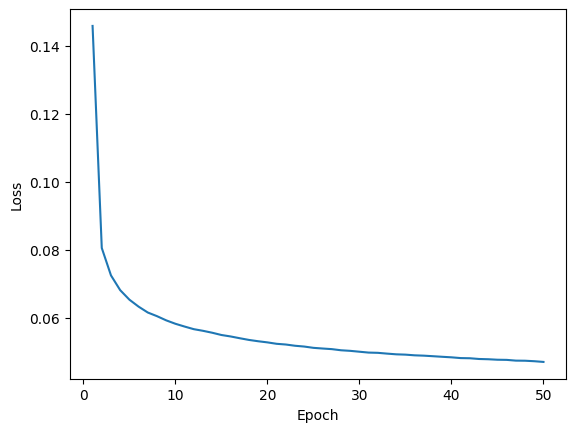

Mean MSE on test dataset: 0.1068


In [66]:
seed_everything(464)
model_fc = MnistAutoencoderFC() ## Uncomment when the model is implemented

# Initialize the optimizer
optimizer = optim.Adam(model_fc.parameters(), lr=2e-4)

# Train the model
train_results = train_model(model_fc, train_dataloader, optimizer, nn.MSELoss(), 50)

# Loss vs Epoch plot
plt.plot(range(1, 51), train_results)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the model
mean_mse = evaluate_model(model_fc, test_dataloader)
print(f"Mean MSE on test dataset: {mean_mse:.4f}")


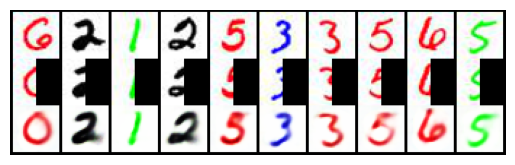

In [67]:
visualize_inpainting(model_fc, test_dataset) ## Uncomment when the model is trained

### **Training and Evaluating the Convolutional Model [5 Points]**

Apply the same steps given in the FC Autoencoder part.

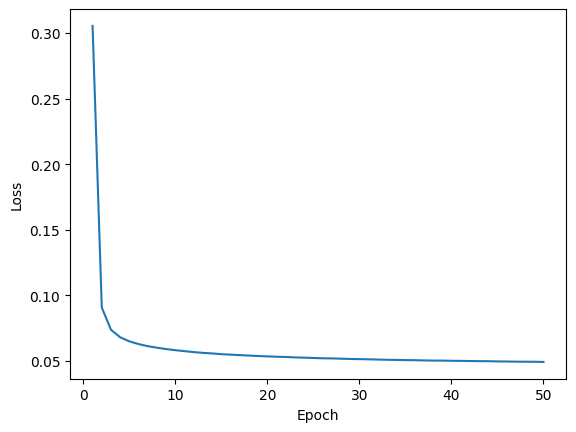

Mean MSE on test dataset: 0.0505


In [68]:
seed_everything(464)
model_conv = MnistAutoencoderConv() ## Uncomment when the model is implemented

# Initialize the optimizer
optimizer = optim.Adam(model_conv.parameters(), lr=2e-4)

# Train the model
train_results = train_model(model_conv, train_dataloader, optimizer, nn.MSELoss(), 50)

# Loss vs Epoch plot
plt.plot(range(1, 51), train_results)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the model
mean_mse = evaluate_model(model_conv, test_dataloader)
print(f"Mean MSE on test dataset: {mean_mse:.4f}")

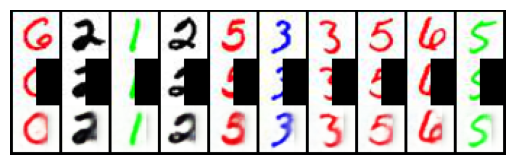

In [69]:
visualize_inpainting(model_conv, test_dataset) ## Uncomment when the model is trained

### **Discussion [10 Points]**

Discuss the results that you obtained after training the models. Compare the inpainting performances by the visualizations and the accuracy metrics. You can write your answer in the below cell.

---

**Write here**

---

The Loss-Epoch plots clearly show that the FC model minimizes its loss slower than the convolutional model. And its MSE on the dataset is doubles the MSE of convolutional model. The reason could be that the FC model works on the flattened images, which loses information like dimensions and spatiality. Convolutional model uses max pooling between layers to reduce dimensions, this helps to choose better principal components rather than choosing from flattened images. This can be seen from the furthered reduced MSE of the convolutional model.

The differences also manifest themselves on the inpainting visualizations. The last row of FC model becomes more blurry in the half that was masked previously. In the last row of convolutional model, the numbers remain as sharp as before but there is a very faint line resembling the masked part. The information loss appears as a blurry image, meanwhile the convolutional model is able to clearly rewrite the number.